<a href="https://colab.research.google.com/github/philipilono/BSL-recognition/blob/main/BSL_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"philipilono","key":"6103c14c8874379d80f5d1f7263b3a68"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d philipilono/bsl-static-alphabet
!unzip /content/bsl-static-alphabet.zip -d bsl-static-alphabet

Streaming output truncated to the last 5000 lines.
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y145 flip.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y145.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1450 flip.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1450.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1451 flip.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1451.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1452 flip.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1452.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1453 flip.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1453.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1454 flip.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1454.jpg  
  inflating: bsl-static-alphabet/Dataset/Dataset/train/Y/Y1455 flip.jpg  
  inflating: bsl-st

In [ ]:
from tensorflow import keras
from tqdm import tqdm
# Imports for Deep Learning
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.models import Sequential, load_model, Model

# Ensure consistency across runs
from numpy.random import seed
import random
seed(2)
tf.random.set_seed(2)

# Imports to view data
import cv2
from glob import glob

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

# Utils
from pathlib import Path
import pandas as pd
import numpy as np
from os import getenv
import time
import itertools

# Image Preprocessing
from skimage.filters import sobel, scharr

import os

In [ ]:
TRAIN_DIR = '/content/bsl-static-alphabet/Dataset/Dataset/train'
TEST_DIR = '/content/bsl-static-alphabet/BSL-data/Dataset/test'
# CUSTOM_TEST_DIR = '/content/asl-alphabet-test/asl-alphabet-test/'

IMG_SIZE = 64
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)
TARGET_DIMS = (IMG_SIZE, IMG_SIZE, 3) # add channel for RGB
N_CLASSES = 24
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 16

# Model saving for easier local iterations
MODEL_DIR = '/content/gdrive/MyDrive/project-model/bsl-model/'
MODEL_PATH = MODEL_DIR + '/cnn-model.h5'
MODEL_WEIGHTS_PATH = MODEL_DIR + '/cnn-model.weights.h5'
MODEL_SAVE_TO_DISK = True

In [ ]:
CATEGORIES = [folder[len(TRAIN_DIR) + 1:] for folder in glob(TRAIN_DIR + '/*')]
CATEGORIES.sort()
print(len(TRAIN_DIR))
print('Following classes were found:')
print(', '.join(CATEGORIES))
CATEGORIES = [folder[len(TEST_DIR) + 1:] for folder in glob(TEST_DIR + '/*')]
CATEGORIES.sort()
print(len(TEST_DIR))
print('Following classes were found:')
print(', '.join(CATEGORIES))

50
Following classes were found:
A, B, C, D, E, F, G, I, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z
50
Following classes were found:
A, B, C, D, E, F, G, I, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y, Z


(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)
(200, 200, 3)


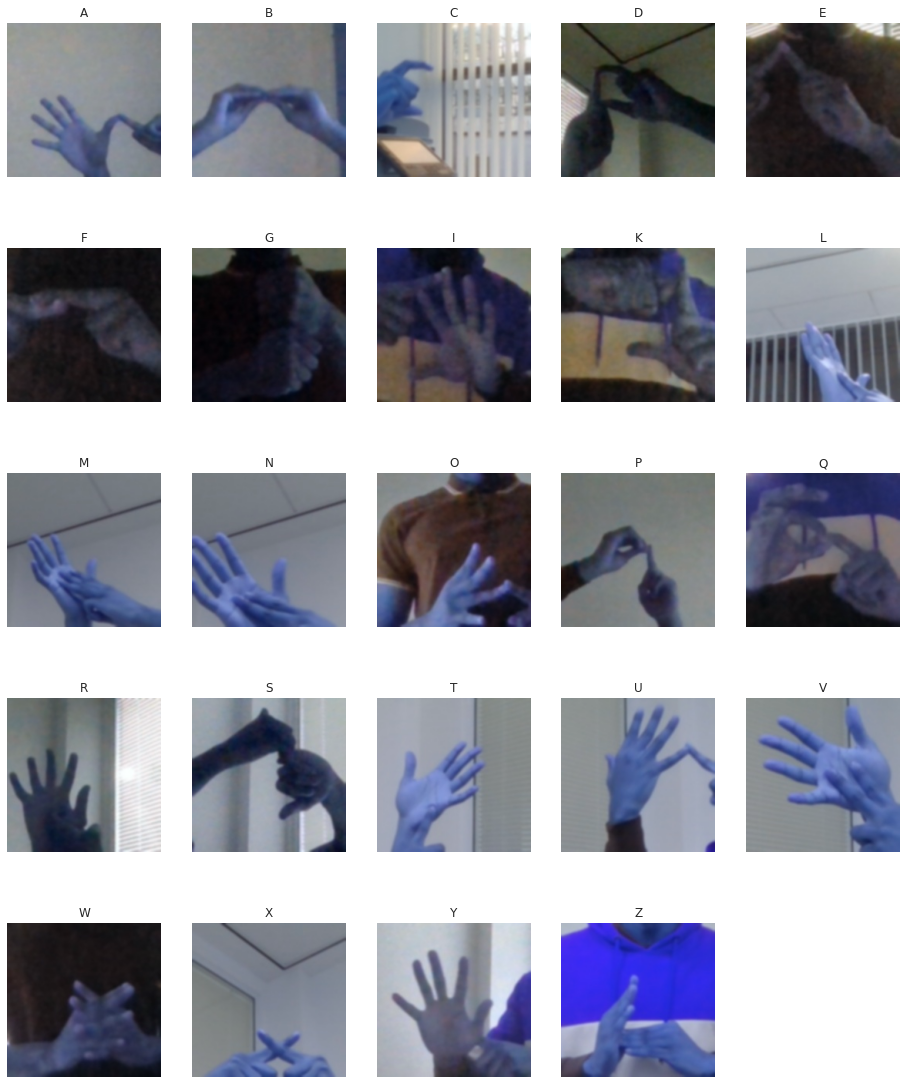

In [ ]:
def plot_one_sample_of_each(base_path):
    cols = 5
    rows = int(np.ceil(len(CATEGORIES) / cols))
    fig = plt.figure(figsize=(16, 20))
    
    for i in range(len(CATEGORIES)):
        cls = CATEGORIES[i]
        img_path = base_path + '/' + cls + '/**'
        path_contents = glob(img_path)
    
        imgs = random.sample(path_contents, 1)

        sp = plt.subplot(rows, cols, i + 1)
        im = cv2.imread(imgs[0])
        print(im.shape)
        plt.imshow(im)
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return

plot_one_sample_of_each(TRAIN_DIR)

In [ ]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do 0,1,2,3, .....

        path = os.path.join(TRAIN_DIR,category)  # create path to categories
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
                # print(new_array.shape)
            except Exception as e:  # in the interest in keeping the output clean...
                pass
     

create_training_data() 


100%|██████████| 3002/3002 [00:02<00:00, 1345.19it/s]


In [ ]:
testdata = []

def create_test_data():
    for category in CATEGORIES:  # do 0,1,2,3, .....
        

        path = os.path.join(TEST_DIR,category)  # create path to categories
        class_num = CATEGORIES.index(category)  # get the classification

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                testdata.append([new_array, class_num])  # add this to our training_data
                # print(new_array.shape)
            except Exception as e:  # in the interest in keeping the output clean...
                pass  
create_test_data() 


100%|██████████| 10/10 [00:00<00:00, 84.59it/s]


In [ ]:
import random
random.shuffle(training_data)

# Check the shuffle
for sample in training_data[:10]:
    print(sample[1])

19
17
13
23
13
5
17
22
21
6


In [ ]:
import random
random.shuffle(testdata)

# Check the shuffle
for sample in testdata[:10]:
    print(sample[1])

8
18
19
11
5
13
6
13
14
20


In [ ]:
print(len(training_data))
test_data = training_data[71031:] 
len(test_data)

72031


1000

In [ ]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y = np.array(Y)
print(X.shape)
print(Y.shape)

#np.save("/content/Kaggle/Working/X.npy", X)
#np.save("/content/Kaggle/Working/Y.npy", Y)

(72031, 64, 64, 3)
(72031,)


In [ ]:
from keras.layers import BatchNormalization
from keras.layers import AlphaDropout
model = Sequential()

model.add(Conv2D(32,(3,3),padding = 'same',input_shape=TARGET_DIMS,activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(256,(3,3),padding = 'same',activation = 'relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(N_CLASSES,activation="softmax"))


model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)        

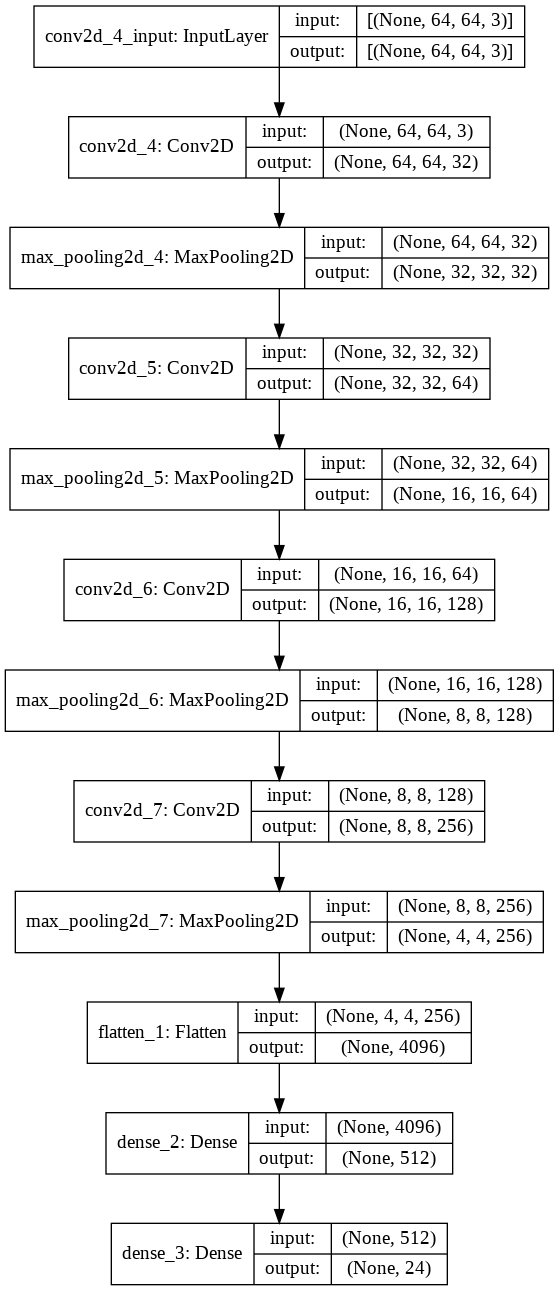

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_filepath = '/content/gdrive/MyDrive/project-model/bsl-model/alpha_sign4.h5'

checkpoint = ModelCheckpoint(checkpoint_filepath, monitor ='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', verbose=1, mode='max', patience=5, min_delta=1e-3)
with tf.device('/device:GPU:0'):
  history = model.fit(X, Y, batch_size=32, epochs=20, verbose=1, callbacks=[checkpoint, earlystop], 
                      validation_split=VALIDATION_SPLIT)

Epoch 1/20
1801/1801 [==============================] - 14s 7ms/step - loss: 1.9882 - accuracy: 0.4321 - val_loss: 0.1354 - val_accuracy: 0.9771

Epoch 00001: val_accuracy improved from -inf to 0.97709, saving model to /content/gdrive/MyDrive/project-model/bsl-model/alpha_sign4.h5
Epoch 2/20
1801/1801 [==============================] - 12s 7ms/step - loss: 0.1548 - accuracy: 0.9524 - val_loss: 0.0028 - val_accuracy: 0.9992

Epoch 00002: val_accuracy improved from 0.97709 to 0.99924, saving model to /content/gdrive/MyDrive/project-model/bsl-model/alpha_sign4.h5
Epoch 3/20
1801/1801 [==============================] - 12s 7ms/step - loss: 0.0713 - accuracy: 0.9773 - val_loss: 0.0075 - val_accuracy: 0.9981

Epoch 00003: val_accuracy did not improve from 0.99924
Epoch 4/20
1801/1801 [==============================] - 12s 7ms/step - loss: 0.0492 - accuracy: 0.9841 - val_loss: 0.0152 - val_accuracy: 0.9985

Epoch 00004: val_accuracy did not improve from 0.99924
Epoch 5/20
1801/1801 [=========

In [ ]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)
print(X_test.shape)
print(Y_test.shape)


#np.save(MODEL_DIR+"X_test.npy", X_test)
#np.save(MODEL_DIR+"Y_test.npy", Y_test)

(1000, 64, 64, 3)
(1000,)


In [ ]:
loss,acc = model.evaluate(X_test,Y_test)
print(f"Accuracy: {acc*100}")
print(f"Loss: {loss}")

32/32 [==============================] - 0s 4ms/step - loss: 0.0140 - accuracy: 0.9970
Accuracy: 99.6999979019165
Loss: 0.014035996980965137
